In [40]:
using Statistics
using CairoMakie
using CairoMakie.Colors
include("src-fig/plotting.jl")
foldername = "../scratch/turbulence-at-fronts/Strain"

iterations, times = iterations_times(foldername)
sp = simulation_parameters(foldername)
xsᶜ, xsᶠ, ysᶜ, ysᶠ, zsᶜ, zsᶠ = grid_nodes(foldername)
inds = centre_indices(foldername)
frames = [401, 581, 941];

## Movies

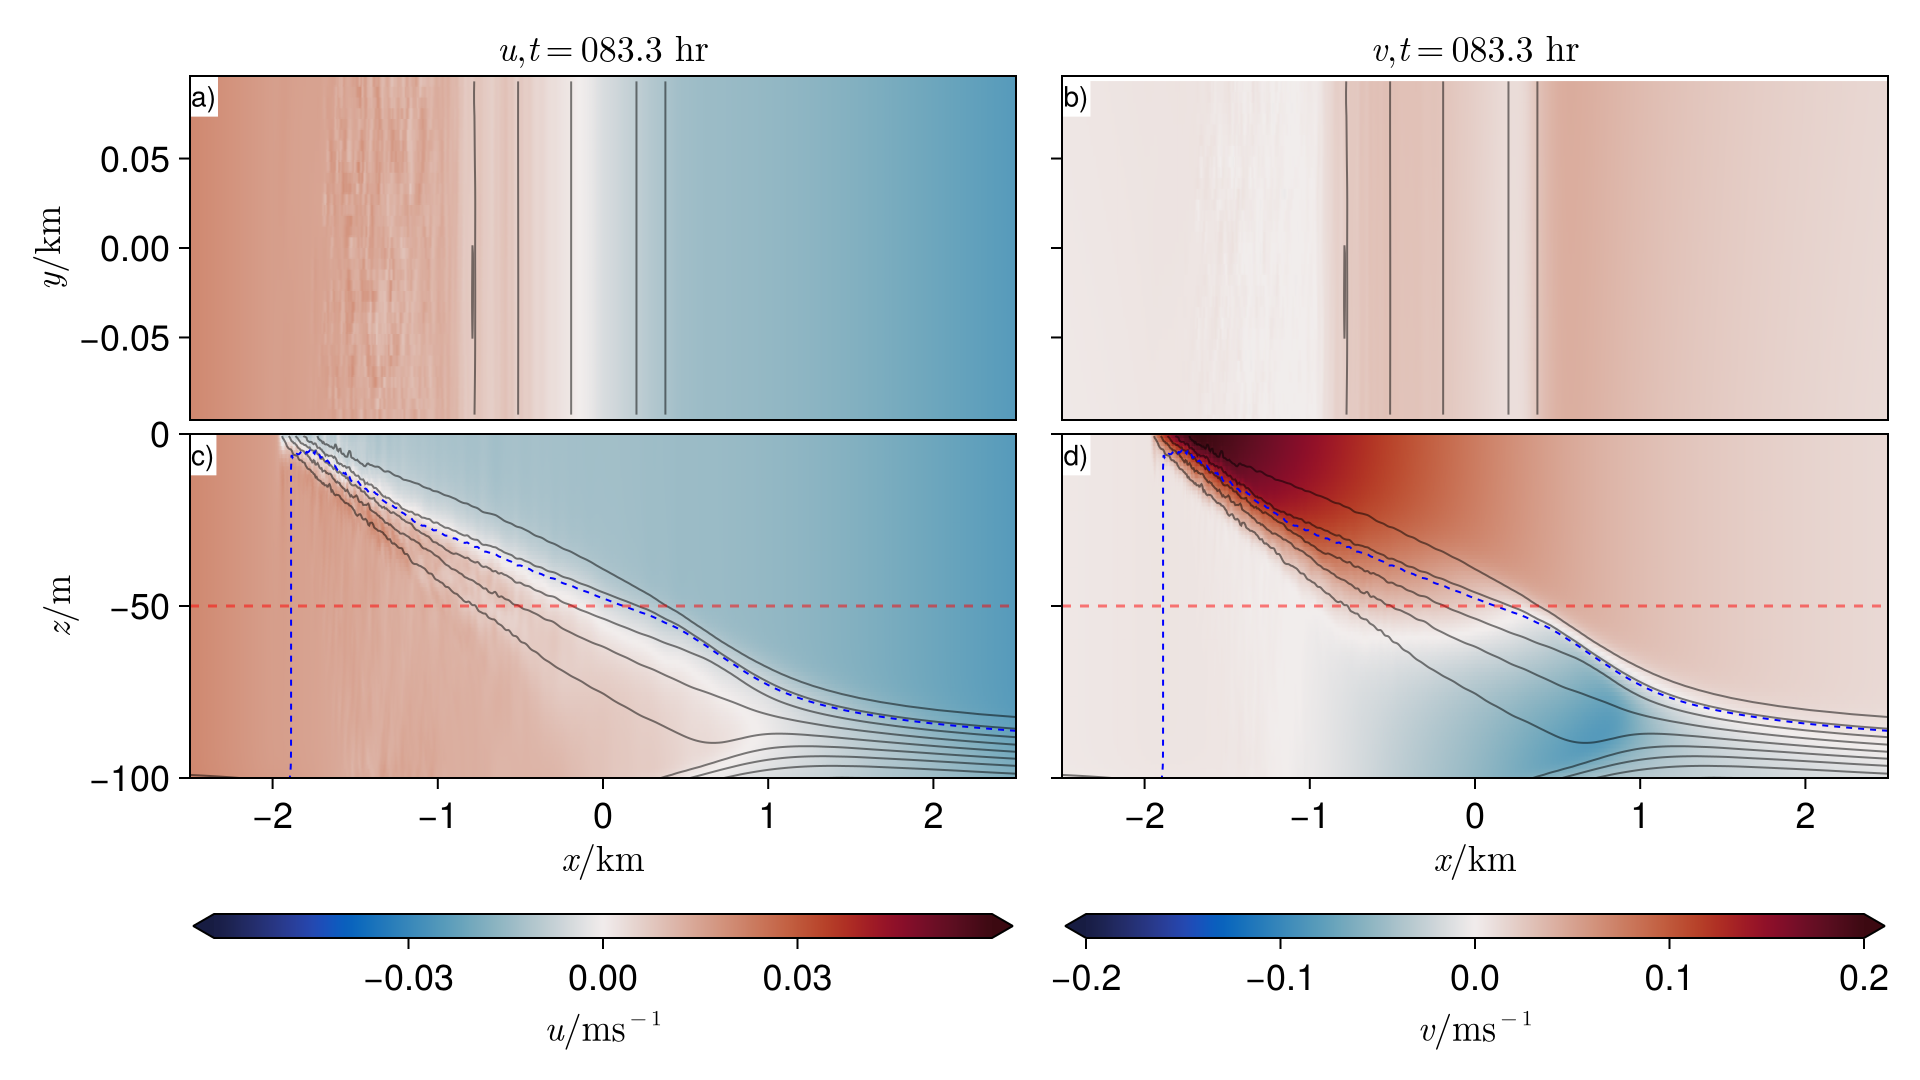

In [15]:
include("src-fig/video/uv_video.jl")

uv_video(foldername, "uv_NoCooling.mp4", [401], -50; background=true, fig_kw=(; fontsize=18), record_kw=(; px_per_unit=2))

801 / 801 


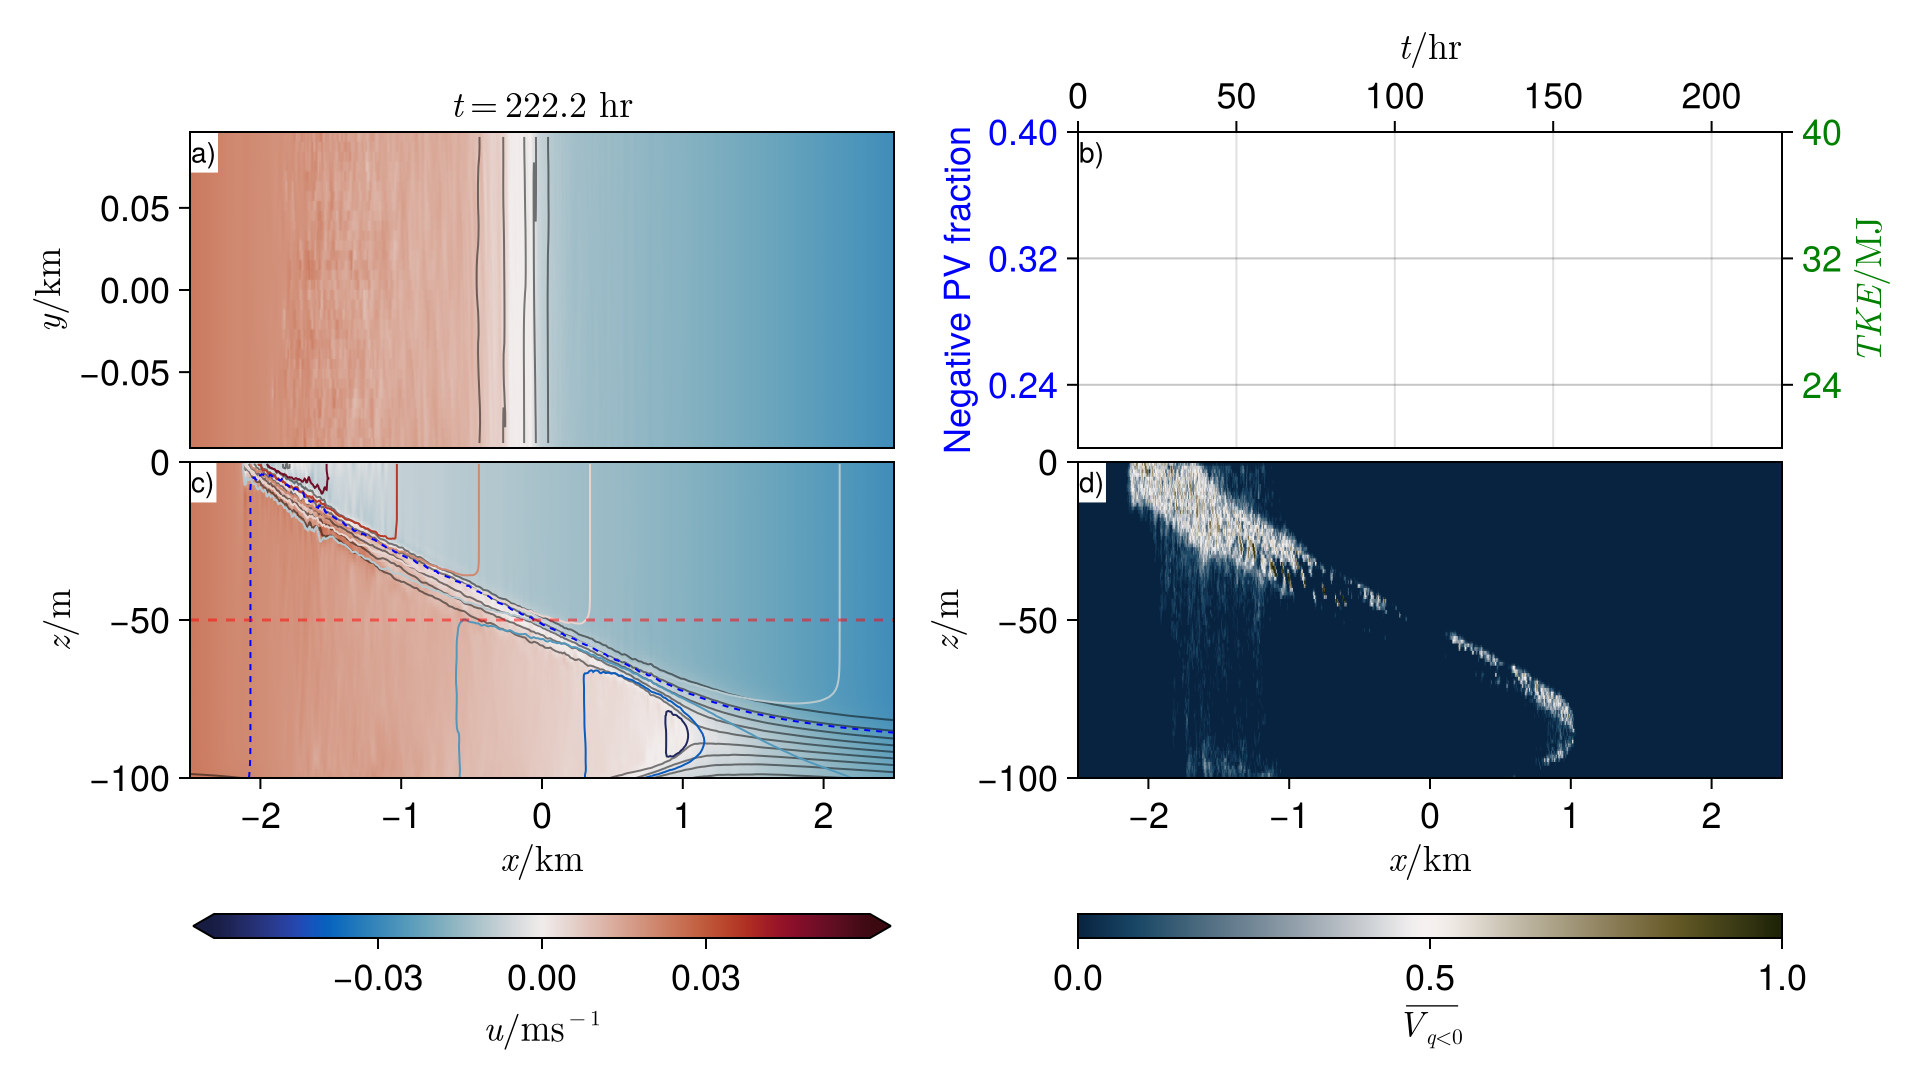

In [46]:
include("src-fig/video/full_video.jl")

full_video(foldername, "full-NoCooling.mp4", 1:801, -50; background=true, fig_kw=(; fontsize=18), record_kw=(; px_per_unit=2))

## Attempt at a cartoon

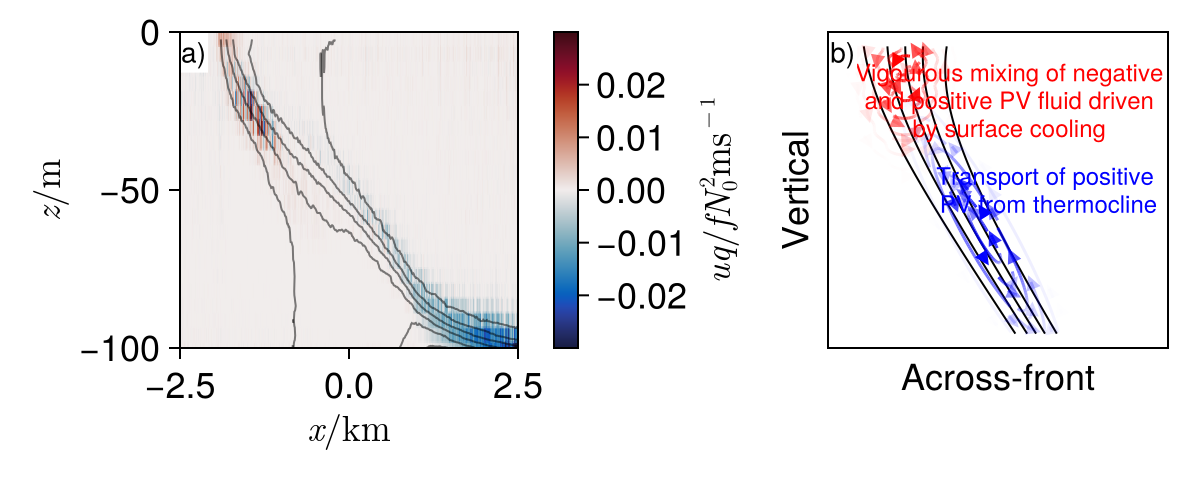

In [49]:
xs = range(-0.9, 1.1, 1000)
zs = range(-1, 0, 1000)

fig = Figure(; size=(600, 240), fontsize=18)
ax = Axis(fig[1, 3]; xlabel="Across-front", ylabel="Vertical")

arrest_x = -0.5
arrest_z = -0.1

σ = 0.1
dx = arrest_x - 0.5
dz = arrest_z - 1.0
dl = sqrt(dx^2 + dz^2)
arrest_n = [dx; dz] ./ dl
arrest_m = [-dz; dx] ./ dl

entrainment_x = arrest_x - dx / 2
entrainment_z = arrest_z + dz / 2

Σ² = arrest_n * (4/σ^2) * transpose(arrest_n) + arrest_m * (40/dl^2) * transpose(arrest_m)

# Arrest region streamfunction 
function arrest_ψ(x, z) 
    r = (x-arrest_x)^2 + (z-arrest_z)^2
    -exp(-r / 2σ^2) * (1 + 0.2 * sin(100z))
end

arrest_colormap = [RGBA(1, 0, 0, 0), RGBA(1, 0, 0, 1)]

arrest_u(x, z) = -(arrest_ψ(x, z+5e-5) - arrest_ψ(x, z-5e-5)) / 1e-4
arrest_w(x, z) = (arrest_ψ(x+5e-5, z) - arrest_ψ(x-5e-5, z)) / 1e-4

arrest_U(x, z) = Point2(arrest_u(x, z), arrest_w(x, z))

# Entrainment region streamfunction
function entrainment_ψ(x, z) 
    r = [x-entrainment_x; z-entrainment_z]
    -exp(-transpose(r) * Σ² * r/ 2)
end
entrainment_colormap = [RGBA(0, 0, 1, 0), RGBA(0, 0, 1, 1)]

function entrainment_u(x, z) 
    u = -(entrainment_ψ(x, z+5e-5) - entrainment_ψ(x, z-5e-5)) / 1e-4
    return u
end
function entrainment_w(x, z) 
    w = (entrainment_ψ(x+5e-5, z) - entrainment_ψ(x-5e-5, z)) / 1e-4
    return w
end

entrainment_U(x, z) = Point2(entrainment_u(x, z), entrainment_w(x, z))

function buoyancy(x, z)
    tanh(3abs(z-1)*(x -(-1+0.5* sqrt(1+(2.5z)^2))))
end

contour!(ax, xs, zs, buoyancy; color=:black)
streamplot!(ax, arrest_U, xs, zs; colormap=arrest_colormap, arrow_size=10)
streamplot!(ax, entrainment_U, xs, zs; colormap=entrainment_colormap, arrow_size=10)
gl = GridLayout(fig[1, 3], 
    tellwidth = false, 
    tellheight = false, 
    halign = 0.95, 
    valign = 0.5,
)
Label(gl[1, 1], "Transport of positive \nPV from thermocline";
    fontsize=12,
    padding = (1, 1, 2, 2),
    color=:blue
)
gl = GridLayout(fig[1, 3], 
    tellwidth = false, 
    tellheight = false, 
    halign = 0.9, 
    valign = 0.9,
)
Label(gl[1, 1], "Vigourous mixing of negative\nand positive PV fluid driven\nby surface cooling";
    fontsize=12,
    padding = (1, 1, 2, 2),
    color=:red
)
hidexdecorations!(ax; label=false)
hideydecorations!(ax; label=false)

uq = get_field(joinpath(foldername, "PV.jld2"), "uq_dfm", iterations[1201]) do field
    filt(field, 0, 0) ./ (sp.f * sp.N₀²)
end
b = get_field(joinpath(foldername, "DFM.jld2"), "b_dfm", iterations[1201])

ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", limits=(-sp.Lh / 2000, sp.Lh / 2000, -sp.H, 0))
ht = heatmap!(ax, xsᶠ ./ 1000, zsᶜ, uq; colormap=:balance, colorrange=(-0.03, 0.03))
contour!(ax, xsᶜ ./ 1000, zsᶜ, b; color=(:black, 0.5), levels=b_levels)

Colorbar(fig[1, 2], ht; label=L"uq / fN_0^2 \text{m}\text{s}^{-1}")

subfig_label!(fig[1, 1], 1)
subfig_label!(fig[1, 3], 2)

save("figures/paper/cartoon.png", fig; px_per_unit=2)

fig

## Frontal evolution

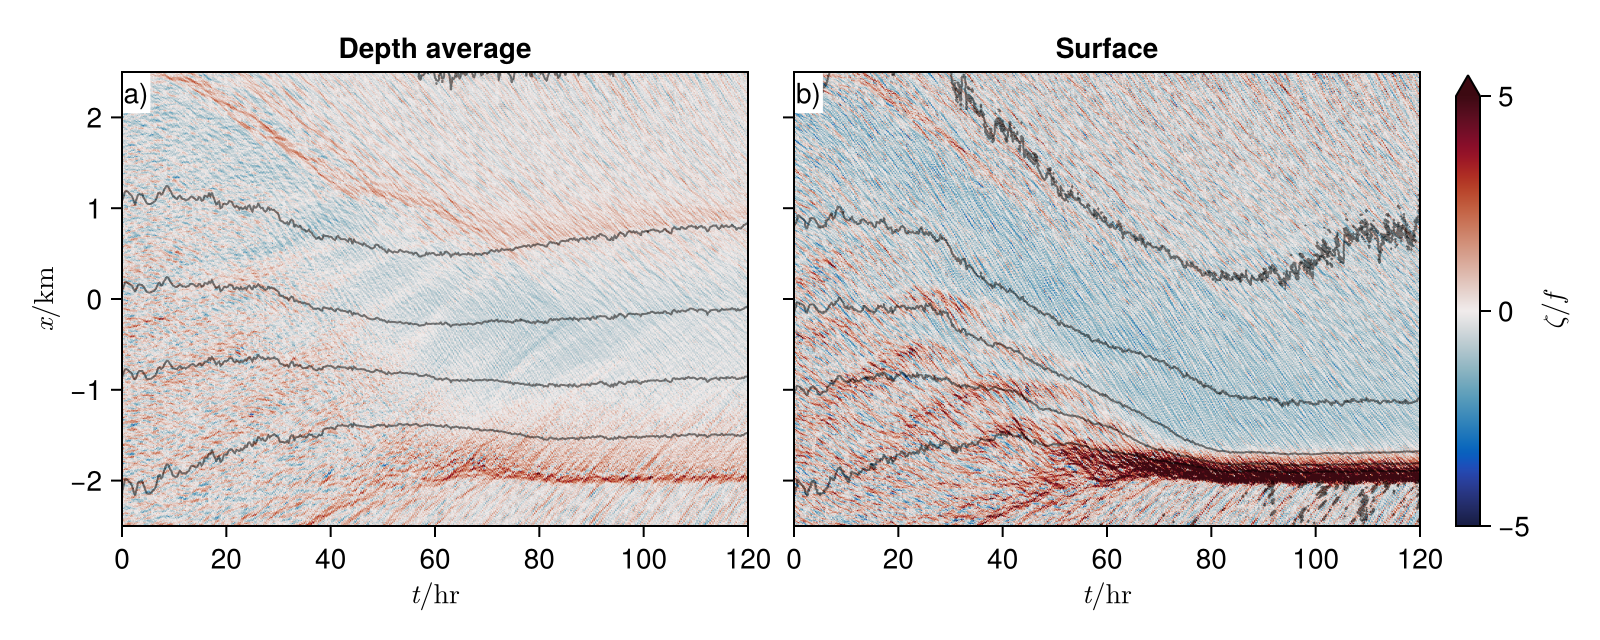

In [27]:
include("src-fig/frontogenesis.jl")

# Presentation
fig = frontogenesis(foldername; ax_kw=(; limits=(0, 120, -2.5, 2.5)), ht_kw=(; colorrange=(-5, 5)), σ=(0, 0, 0), fig_kw=(; size=(800, 320), fontsize=18))
save("figures/presentation/frontogenesis.png", fig; px_per_unit=2)
#save("figures/presentation/frontogenesis.svg", fig)

# Paper
fig = frontogenesis(foldername; ax_kw=(; limits=(0, 120, -2.5, 2.5)), ht_kw=(; colorrange=(-5, 5)), σ=(0, 0, 0), fig_kw=(; size=(800, 320)))
save("figures/paper/frontogenesis.png", fig; px_per_unit=2)
#save("figures/paper/frontogenesis.svg", fig)

fig

## Hovmoller

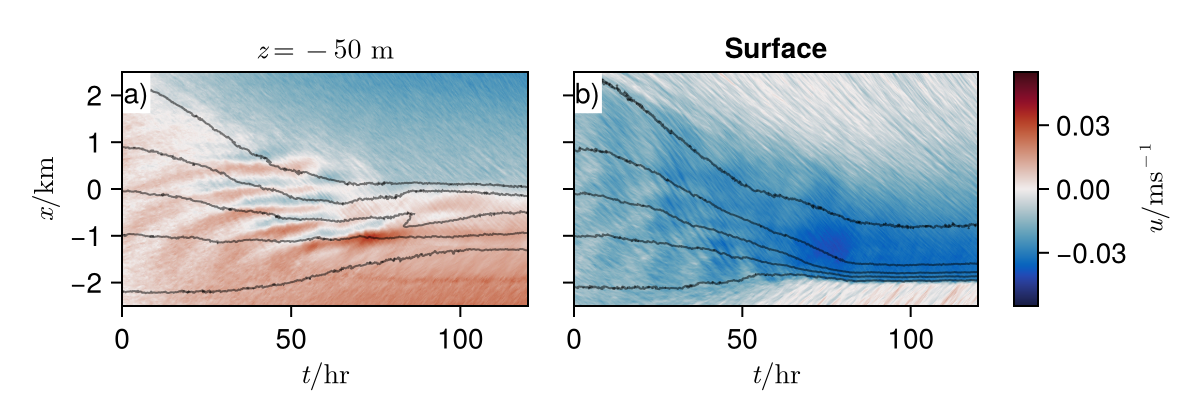

In [48]:
include("src-fig/hovmoller.jl")

# Presentation
#fig = hovmoller(foldername, -50; ax_kw=(; limits=(0, 120, -2.5, 2.5)), ht_kw=(; colorrange=(-0.055, 0.055)), σ=0, fig_kw=(; size=(800, 320), fontsize=18), background=true)
#save("figures/presentation/hovmoller.png", fig; px_per_unit=2)
#save("figures/presentation/hovmoller.svg", fig)

# Paper
fig = hovmoller(foldername, -50; fig_kw=(; size=(600, 210)), ax_kw=(; limits=(0, 120, -2.5, 2.5), xticks=[0, 50, 100]), ht_kw=(; colorrange=(-0.055, 0.055)), σ=0, background=true)
save("figures/paper/hovmoller.png", fig; px_per_unit=2)
#save("figures/paper/hovmoller.svg", fig)

fig

## Across-front velocity

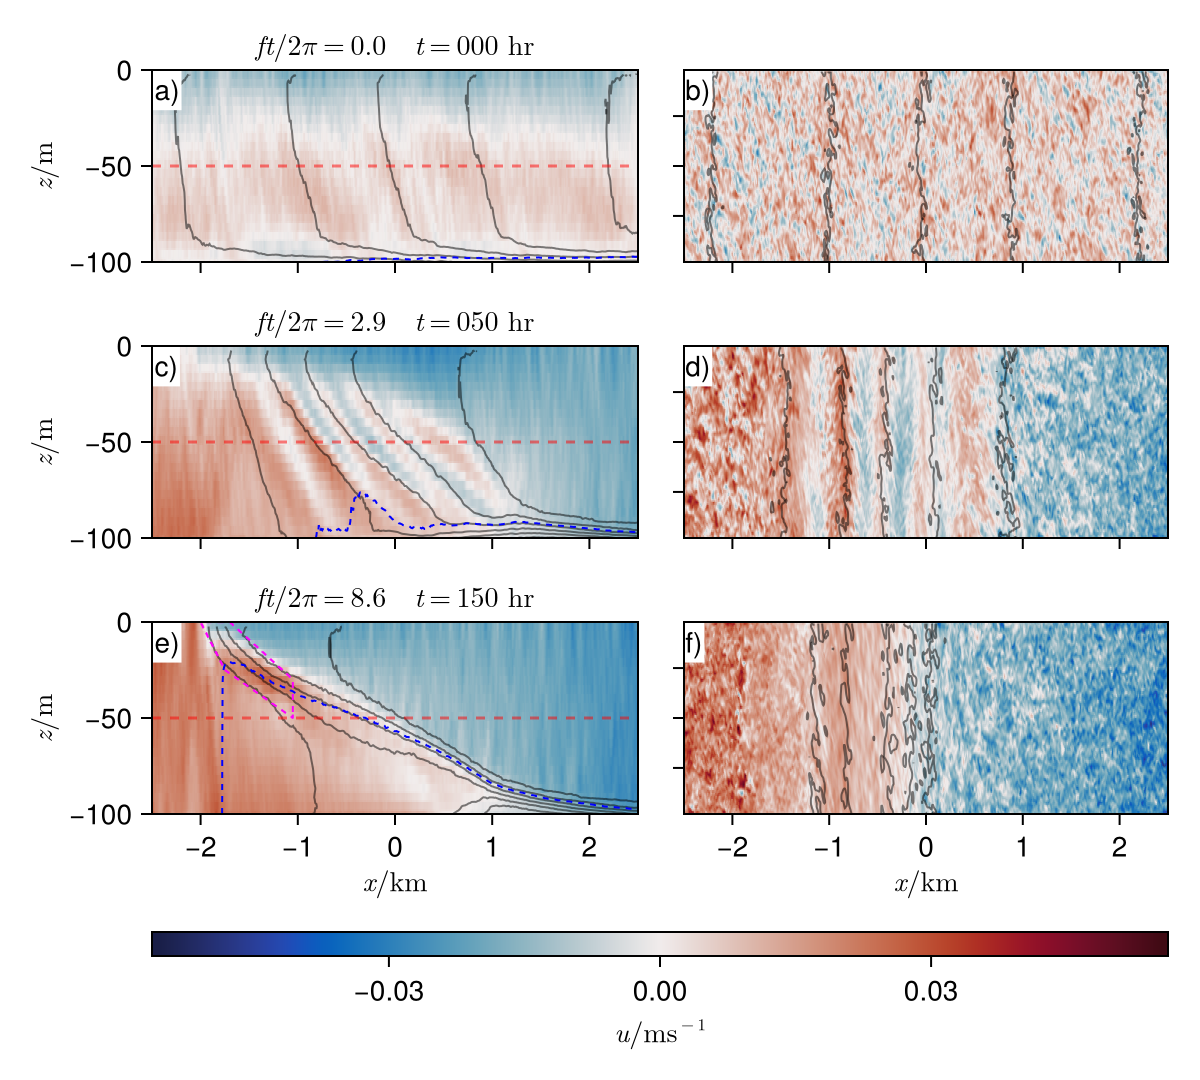

In [53]:
include("src-fig/u_evolution.jl")
include("src-fig/regions.jl")

# Presentation
fig = u_evolution(foldername, frames, -50, regions.arrest; fig_kw=(; size=(800, 720), fontsize=18), background=true)
#save("figures/presentation/u-evolution.svg", fig)
#save("figures/presentation/u-evolution.png", fig; px_per_unit=2)

# Snapshots
#for frame in frames
#    fig = u_evolution(foldername, [frame], -50; fig_kw=(; size=(800, 320), fontsize=18), background=true)
#    save("figures/presentation/snapshot_$frame.png", fig; px_per_unit=2)
#end
# Paper
fig = u_evolution(foldername, frames, -50, regions.arrest; fig_kw=(; size=(600, 540)), background=true)
#save("figures/paper/u-evolution.svg", fig)
save("figures/paper/u-evolution.png", fig; px_per_unit=2)

fig

## Turbulent kinetic energy

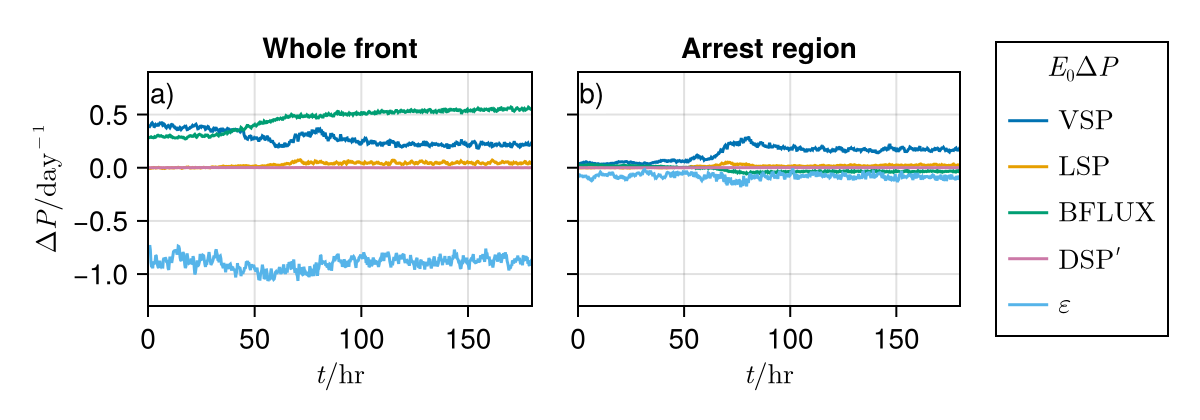

In [43]:
include("src-fig/region_plots.jl")
include("src-fig/regions.jl")

# Presentation
#fig = tke_by_region(foldername, []; ax_kw=(; limits=(0, 200, -1.3, 1.3)), fig_kw=(; fontsize=18))
#save("figures/presentation/tke.svg", fig)
#save("figures/presentation/tke.png", fig; px_per_unit=2)

# Paper
fig = tke_by_region(foldername, []; fig_kw=(; size=(600, 210)), ax_kw=(; xticks=[0, 50, 100, 150], limits=(0, 180, -1.3, 0.9)))
#save("figures/paper/tke.svg", fig)
save("figures/paper/tke.png", fig; px_per_unit=2)

fig

## Potential vorticity

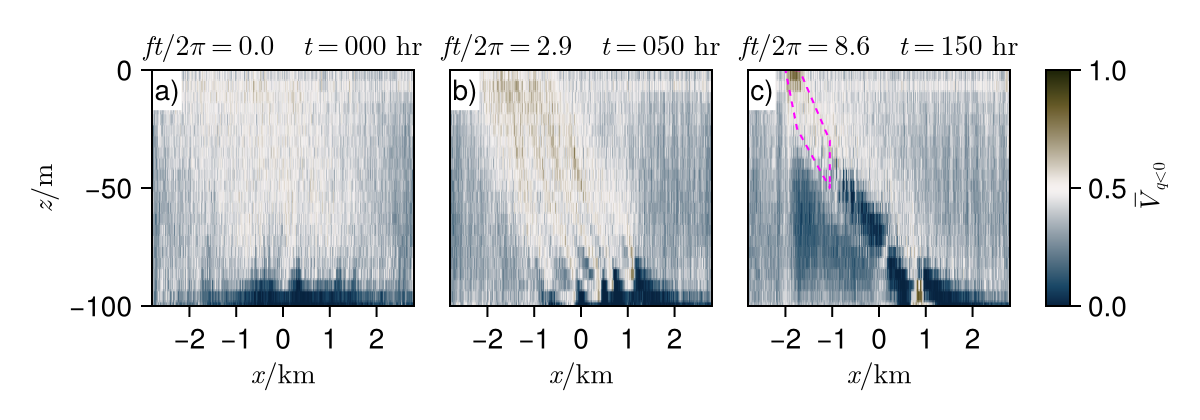

In [44]:
include("src-fig/pv_plot.jl")

# Presentation
#fig = instability_plot(foldername, [1, 230, 360]; fig_kw=(; size=(800, 240), fontsize=18), ax_kw=(; xticks=-2:2))
#save("figures/presentation/pv.svg", fig)
#save("figures/presentation/pv.png", fig; px_per_unit=2)

# Paper
fig = instability_plot(foldername, frames, regions.arrest; fig_kw=(; size=(600, 210)), ax_kw=(; xticks=-2:2, limits=(-2.8, 2.8, -100, 0)))
#save("figures/paper/pv.svg", fig)
save("figures/paper/pv.png", fig; px_per_unit=2)

fig

## Horizontal velocity balance

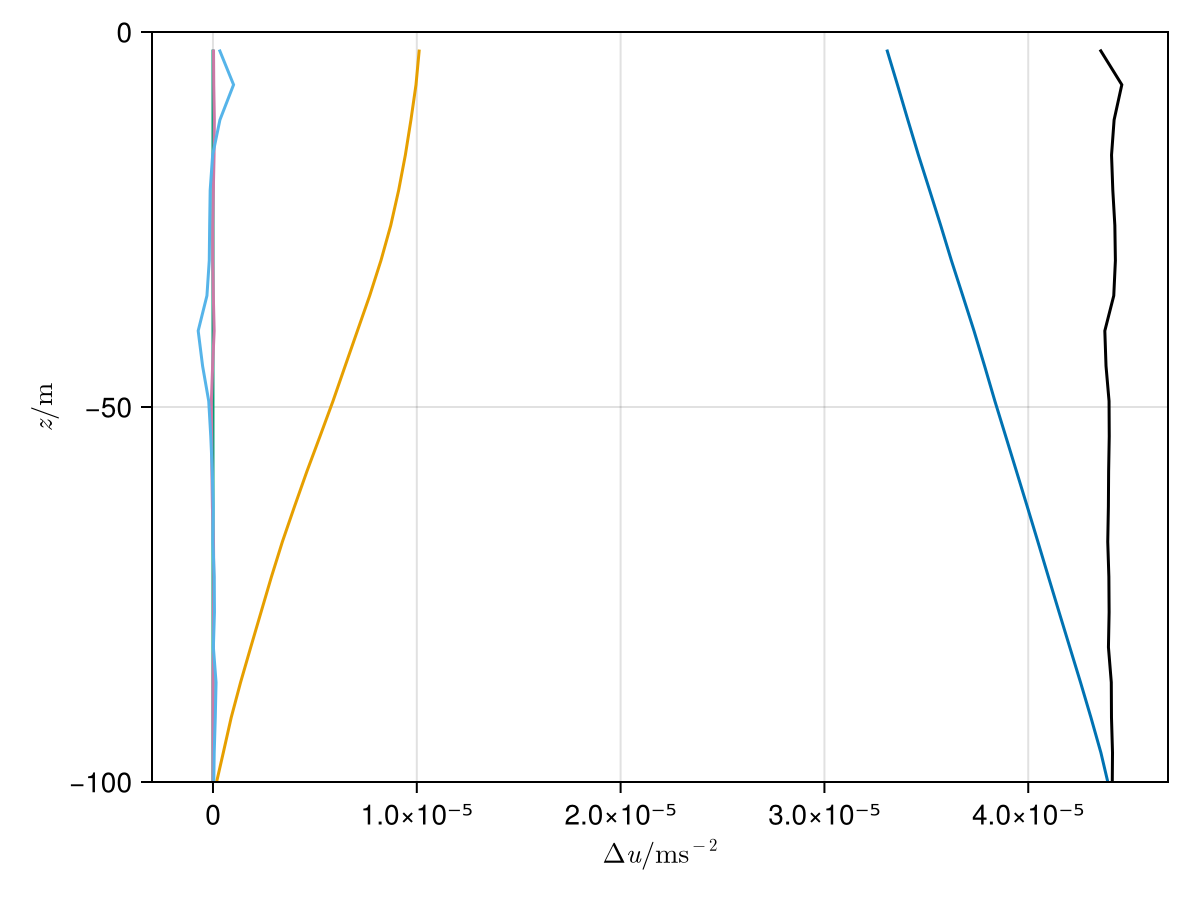

In [65]:
# Initial horizontal velocity

fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"\Delta u / \text{ms}^{-2}", ylabel=L"z / \text{m}", limits=(nothing, nothing, -sp.H, 0))
horizontal_avg(a) = mean(a[inds[400:500], :]; dims=1)[1, :]

p = timeseries_of(horizontal_avg, joinpath(foldername, "UBALANCE.jld2"), "pressure", iterations)
fv = timeseries_of(horizontal_avg, joinpath(foldername, "UBALANCE.jld2"), "coriolis", iterations)
αu = timeseries_of(horizontal_avg, joinpath(foldername, "UBALANCE.jld2"), "background_strain", iterations)

th = timeseries_of(horizontal_avg, joinpath(foldername, "UBALANCE.jld2"), "turbulence_h_dfm", iterations)
tz = timeseries_of(horizontal_avg, joinpath(foldername, "UBALANCE.jld2"), "turbulence_z_dfm", iterations)

n = 398:398

lines!(ax, mean(p[n, :]; dims=1)[1, :], zsᶜ)
lines!(ax, mean(fv[n, :]; dims=1)[1, :], zsᶜ)
lines!(ax, mean(αu[n, :]; dims=1)[1, :], zsᶜ)
lines!(ax, mean(th[n, :]; dims=1)[1, :], zsᶜ)
lines!(ax, mean(tz[n, :]; dims=1)[1, :], zsᶜ)
total = p .+ fv .+ tz .+ αu .+ th
lines!(ax, mean(total[n, :]; dims=1)[1, :], zsᶜ, color=:black)

fig